# Assignment 9: Denoising Diffusion Models - Kai Ponel & Hannan Mahadik

## Imports


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Lambda

tfpd = tfp.distributions
tfk = tf.keras
tfkl = tfk.layers

## Dataset

In [ ]:
batch_size = 512

(train_images, _), (test_images, _) = mnist.load_data()
print(train_images.shape)
train_images = np.pad(train_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0))).astype(np.float32) / 255.
test_images = np.pad(test_images[..., None], ((0, 0), (2, 2), (2, 2), (0, 0))).astype(np.float32) / 255.

train_data = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices(test_images).batch(32)

(60000, 28, 28)


In [ ]:
train_images.shape

(60000, 32, 32, 1)

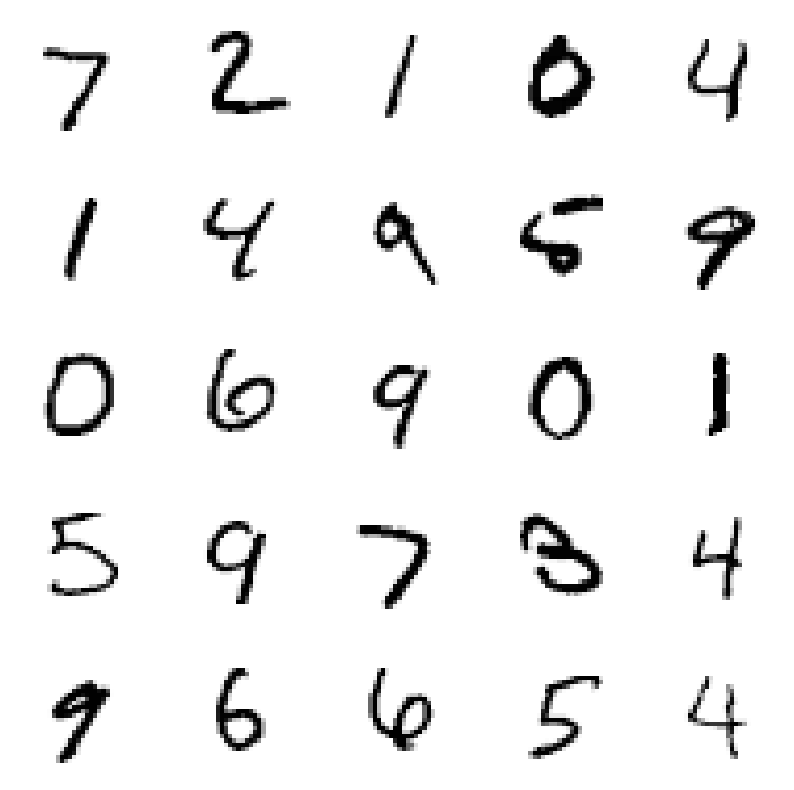

In [ ]:
test_images = np.concatenate([batch for batch in iter(test_data)], axis=0)

plt.figure(figsize=(10,10))
for ind, img in enumerate(test_images[:25]):
    plt.subplot(5, 5, ind+1)
    plt.imshow(img, vmin=0, vmax=1, cmap="Greys")
    plt.axis("off")
plt.show()

## Forward Process
Step-wise addition of noise to image for x time-steps

In [ ]:
n_freqs = 9
tmax = 1000
betas = np.linspace(0.0001, 0.02, tmax).astype(np.float32)
alphas = 1 - betas
alphas_bar = np.cumprod(alphas)

In [ ]:



def forward_process(img, t):
    scale = np.sqrt(1 - alphas_bar[t])
    mean = np.sqrt(alphas_bar[t]) * img + scale * np.random.normal(size=img.shape)
    dist = tfp.distributions.Normal(loc=mean, scale=scale)
    new_img = dist.sample(1)
    new_img = tf.squeeze(new_img, axis=0)
    return new_img

In [ ]:
sample_index = 0
timestep = 2
time_steps = [1, 2, 5, 10, 20, 50, 100, 500, tmax]

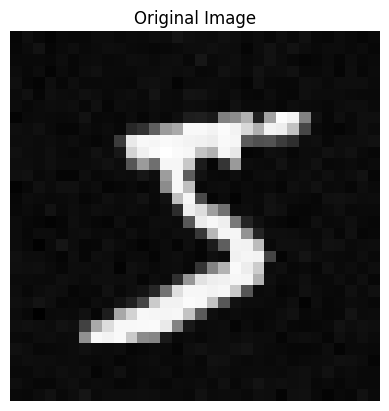

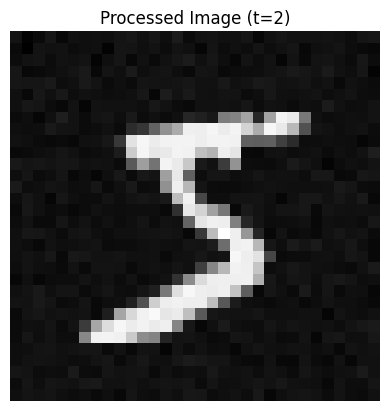

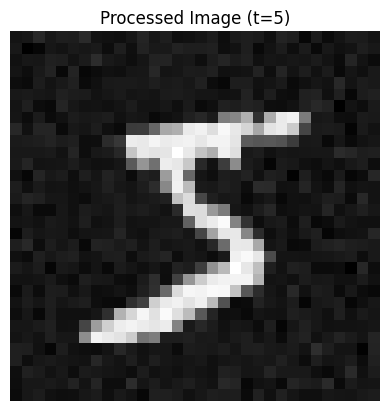

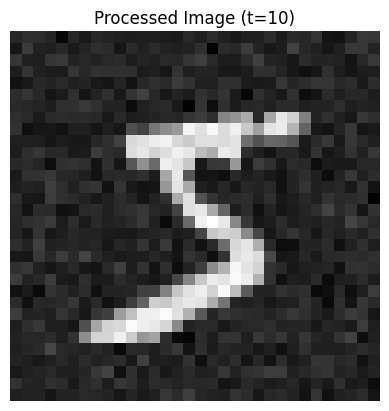

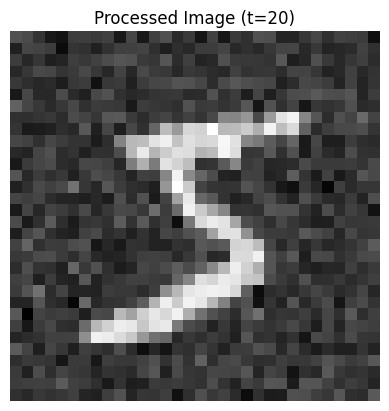

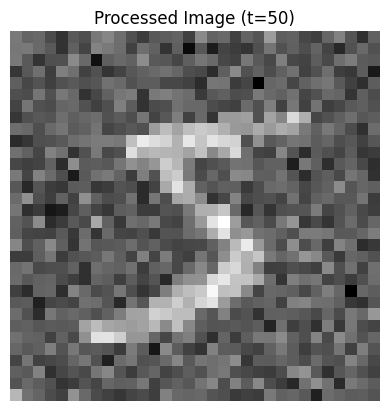

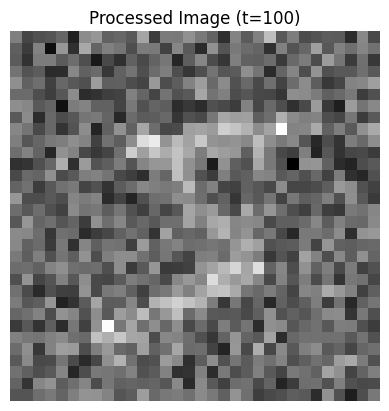

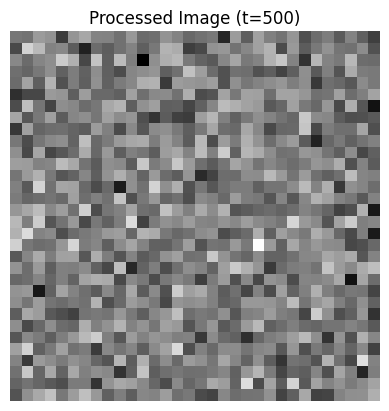

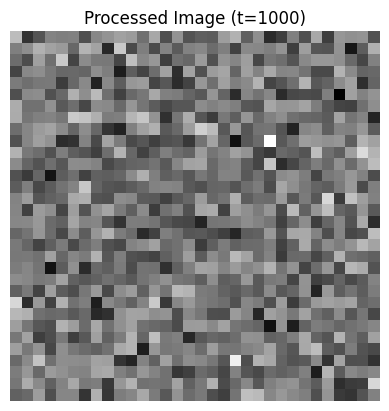

In [ ]:
for t in time_steps:
    input_img = train_images[sample_index]
    output_img = forward_process(input_img, t - 1)
    if(t == 1):
      plt.title('Original Image')
      plt.imshow(output_img, cmap='gray')
      plt.axis('off')
      plt.show()
    else:
      plt.title('Processed Image (t={})'.format(t))
      plt.imshow(output_img, cmap='gray')
      plt.axis('off')
      plt.show()

## Positional Encoding

In [ ]:
def positional_encoding(input_t, n_freqs):
    # input_t: b x 1
    # n_freqs: scalar
    # returns b x (2*n_freqs)
    exponents = tf.range(n_freqs, dtype=tf.float32)  # n_freqs vector
    frequencies = tf.pow(2., exponents)  # same
    sines = tf.math.sin(2*np.pi*frequencies*input_t)  # b x n_freqs
    cosines =  tf.math.cos(2*np.pi*frequencies*input_t)  # b x n_freqs
    return tf.concat([sines, cosines], axis=-1)  # b x 2*n_freqs

## Diffusion Model

### Forward process function

In [ ]:
def forward_process_training(img, t, rnd_noise):
  mean = np.reshape(np.sqrt(alphas_bar[t]), (t.shape[0], 1, 1, 1)) * img
  scale = np.reshape(np.sqrt((1-alphas_bar[t])).astype("float32"), (t.shape[0], 1, 1, 1))
  new_img = mean + scale * rnd_noise
  return new_img

### Loss function

In [ ]:
def squared_error(target, predicted):
  return tf.reduce_sum((target - predicted) ** 2)

### Model

In [ ]:
class DiffusionModel(tfk.models.Model):
  def __init__(self, **kwargs):
    super(DiffusionModel, self).__init__(**kwargs)
    self.distrib = tfp.distributions.Normal(loc=0, scale=1)

    # ENCODER
    self.conv2_1 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu2_1 = tfk.layers.ReLU()
    self.conv2_2 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu2_2 = tfk.layers.ReLU()
    self.maxpool2 = tfk.layers.MaxPool2D()

    self.conv3_1 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu3_1 = tfk.layers.ReLU()
    self.conv3_2 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu3_2 = tfk.layers.ReLU()
    self.maxpool3 = tfk.layers.MaxPool2D()

    self.conv4_1 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu4_1 = tfk.layers.ReLU()
    self.conv4_2 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu4_2 = tfk.layers.ReLU()
    self.maxpool4 = tfk.layers.MaxPool2D()

    self.conv5_1 = tfk.layers.Conv2D(512, 3, padding='same')
    self.relu5_1 = tfk.layers.ReLU()
    self.conv5_2 = tfk.layers.Conv2D(512, 3, padding='same')
    self.relu5_2 = tfk.layers.ReLU()

    #DECODER
    self.upconv1 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat1 = tfk.layers.Concatenate()
    self.conv6_1 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu6_1 = tfk.layers.ReLU()
    self.conv6_2 = tfk.layers.Conv2D(256, 3, padding='same')
    self.relu6_2 = tfk.layers.ReLU()

    self.upconv2 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat2 = tfk.layers.Concatenate()
    self.conv7_1 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu7_1 = tfk.layers.ReLU()
    self.conv7_2 = tfk.layers.Conv2D(128, 3, padding='same')
    self.relu7_2 = tfk.layers.ReLU()

    self.upconv3 = tfk.layers.Conv2DTranspose(256, 2, strides=2, padding='same')

    self.concat3 = tfk.layers.Concatenate()
    self.conv8_1 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu8_1 = tfk.layers.ReLU()
    self.conv8_2 = tfk.layers.Conv2D(64, 3, padding='same')
    self.relu8_2 = tfk.layers.ReLU()
    self.conv1x1 = tfk.layers.Conv2D(3, 1, padding='same')

  @tf.function
  def call(self, input):
    (x, t) = input
    t = tf.cast(t, dtype='float32')

    # Positional encoding
    pos_enc = tf.map_fn(lambda te: positional_encoding(te, n_freqs), t)
    pos_features = tf.ones((x.shape[0], x.shape[1], x.shape[2], n_freqs*2)) * pos_enc
    input_with_pos_enc = tf.concat([x, pos_features], axis=-1)

    # Encoder
    x32 = self.relu2_2(self.conv2_2(self.relu2_1(self.conv2_1(input_with_pos_enc))))
    x16 = self.relu3_2(self.conv3_2(self.relu3_1(self.conv3_1(self.maxpool2(x32)))))
    x8 = self.relu4_2(self.conv4_2(self.relu4_1(self.conv4_1(self.maxpool3(x16)))))
    x4 = self.relu5_2(self.conv5_2(self.relu5_1(self.conv5_1(self.maxpool4(x8)))))

    # Decoder
    x8 = self.relu6_2(self.conv6_2(self.relu6_1(self.conv6_1(self.concat1([x8, self.upconv1(x4)])))))
    x16 = self.relu7_2(self.conv7_2(self.relu7_1(self.conv7_1(self.concat2([x16, self.upconv2(x8)])))))
    x32 = self.relu8_2(self.conv8_2(self.relu8_1(self.conv8_1(self.concat3([x32, self.upconv3(x16)])))))
    out = self.conv1x1(x32)

    return out

  @tf.function
  def train_step(self, input):
    ts = np.random.randint(0, tmax, input.shape[0])
    rnd_noise = self.distrib.sample(sample_shape=input.shape)
    diffused_data = forward_process_training(input, ts, rnd_noise)
    with tf.GradientTape() as tape:
      predicted_noise = self.call((diffused_data, ts))
      loss = squared_error(rnd_noise, predicted_noise)
    vars = self.trainable_variables
    grads = tape.gradient(loss, vars)
    self.optimizer.apply_gradients(zip(grads, vars))
    return {
        "squared loss": loss,
    }

In [ ]:
model = DiffusionModel()
optimizer = tfk.optimizers.Adam()
model.compile(optimizer=optimizer)

In [ ]:
model.fit(train_images, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 108s 45ms/step - squared loss: 3939.8254
Epoch 2/10
1875/1875 [==============================] - 84s 45ms/step - squared loss: 2093.4431
Epoch 3/10
1875/1875 [==============================] - 86s 46ms/step - squared loss: 1900.8092
Epoch 4/10
1875/1875 [==============================] - 88s 47ms/step - squared loss: 1863.0032
Epoch 5/10
1875/1875 [==============================] - 91s 49ms/step - squared loss: 599118.4741
Epoch 6/10
1875/1875 [==============================] - 80s 42ms/step - squared loss: 7787.2851
Epoch 7/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 6073.7146
Epoch 8/10
1875/1875 [==============================] - 81s 43ms/step - squared loss: 5235.9760
Epoch 9/10
1875/1875 [==============================] - 88s 47ms/step - squared loss: 4610.0200
Epoch 10/10
1875/1875 [==============================] - 79s 42ms/step - squared loss: 4257.2129


## Sampling

In [ ]:
# Sampling does not work :(
def sample(model, timesteps):
    x_t = tf.random.normal(shape=(1, 32, 32, 1), dtype=tf.float32)
    for t in reversed(range(1, timesteps + 1)):
        # print(x_t.shape)
        z = tf.random.normal(shape=(1, 32, 32, 1), dtype=tf.float32) if t > 1 else 0
        outer_part = tf.sqrt(1.0 / tf.cast(alphas[t - 1], dtype=tf.float32))

        model_input = (x_t, tf.ones((1, 1), dtype=tf.float32) * t)

        epsilon_theta= model((x_t, tf.ones(1)))

        alpha_bar_t = tf.sqrt(tf.cast(alphas_bar[t - 1], dtype=tf.float32) / tf.cast(alphas[t - 1], dtype=tf.float32))

        inner_part = x_t - alpha_bar_t * epsilon_theta
        x_t = outer_part * inner_part + tf.sqrt(tf.cast(betas[t - 1], dtype=tf.float32)) * z
    return x_t

In [ ]:
# Sample images from the trained model
num_samples = 10
sampled_images = []
T = 1000
for _ in range(num_samples):
    sampled_image = sample(model, T)
    sampled_images.append(sampled_image[0])
sampled_images = np.array(sampled_images)

# Reverse scaling of the sampled images
sampled_images = (sampled_images + 1) / 2

# Display the sampled images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i, image in enumerate(sampled_images):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

# Tests

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values to [-1, 1]
x_train = x_train.astype('float32') / 255.0 * 2 - 1
x_test = x_test.astype('float32') / 255.0 * 2 - 1

# Add random noise to the input data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
x_train_noisy = tf.clip_by_value(x_train_noisy, -1.0, 1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, -1.0, 1.0)

In [ ]:
# Define diffusion parameters
T = 1000
betas = np.linspace(0.0001, 0.02, T)
alphas = 1.0 - betas
alpha_bar = np.cumprod(alphas)

# Define the denoising diffusion model
input_shape = (28, 28, 1)
latent_dim = 32

# Encoder
inputs = Input(shape=input_shape)
timesteps = Input(shape=(1,))


# Positional encoding of timesteps
frequencies = [2**i for i in range(n_freqs // 2)]
encoding = Concatenate()([
    tf.math.sin(timesteps * frequency) for frequency in frequencies
] + [
    tf.math.cos(timesteps * frequency) for frequency in frequencies
])
encoding = tf.expand_dims(encoding, axis=1)
encoding = tf.expand_dims(encoding, axis=1)

# Reshape encoding to match input shape
encoding = tf.tile(encoding, [1, input_shape[0], input_shape[1], 1])

# Concatenate encoding with inputs
x = Concatenate()([inputs, encoding])

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Latent space
latent = Conv2D(latent_dim, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(latent)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
outputs = Conv2DTranspose(1, (3, 3), activation='tanh', padding='same')(x)

model = Model([inputs, timesteps], outputs)

# Loss function
def diffusion_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=diffusion_loss)
model.fit([x_train_noisy, np.random.choice(T, size=x_train.shape[0])], x_train,
          batch_size=128, epochs=10, validation_data=([x_test_noisy, np.random.choice(T, size=x_test.shape[0])], x_test))

# Reverse scaling of the data before sampling
x_train = (x_train + 1) / 2
x_test = (x_test + 1) / 2

Epoch 1/10
469/469 [==============================] - 9s 13ms/step - loss: 0.1432 - val_loss: 0.0167
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 8/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 10/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0129 - val_lo

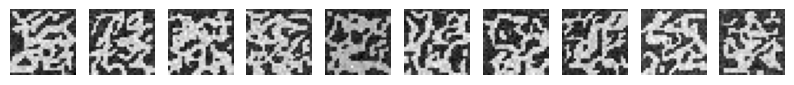

In [ ]:
def sample(model, timesteps):
    x_t = tf.random.normal(shape=(1, 28, 28, 1), dtype=model.inputs[0].dtype)
    for t in reversed(range(1, timesteps + 1)):
        z = tf.random.normal(shape=(1, 28, 28, 1), dtype=model.inputs[0].dtype) if t > 1 else 0
        outer_part = tf.sqrt(1.0 / tf.cast(alphas[t - 1], dtype=model.inputs[0].dtype))
        epsilon_theta=model((x_t, t))
        inner_part = (x_t - ((1-alphas[t])- tf.sqrt((1-alphas_bar[t]))) * epsilon_theta)
        #alpha_bar_t = tf.sqrt(tf.cast(alpha_bar[t - 1], dtype=model.inputs[0].dtype) / tf.cast(alphas[t - 1], dtype=model.inputs[0].dtype))
        #noise = alpha_t * x_t + alpha_bar_t * model([x_t, tf.ones((1, 1), dtype=model.inputs[1].dtype) * t])
        x_t = noise + tf.sqrt(tf.cast(betas[t - 1], dtype=model.inputs[0].dtype)) * z
    return x_t


# Sample images from the trained model
num_samples = 10
sampled_images = []
for _ in range(num_samples):
    sampled_image = sample(model, T)
    sampled_images.append(sampled_image[0])
sampled_images = np.array(sampled_images)

# Reverse scaling of the sampled images
sampled_images = (sampled_images + 1) / 2

# Display the sampled images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i, image in enumerate(sampled_images):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()

In [ ]:
# usage example for positional_encoding

t_max = 1000
batch_size = 32
# in reality, times needs to be a batch_size vector of sampled time steps.
# just like we sample a sigma_i in score-based models.
times = np.random.randint(0, 1000, size=(batch_size, 1))
times_normalized = times.astype(np.float32) / t_max  # to [0, 1]

# how many frequencies to choose?
# generally, we have a sampling rate of t_max for the normalized t.
# the highest frequency that can be expressed (nyquist frequency) is just below t_max/2.
# e.g. for t_max = 1000, frequencies of 500 Hz or higher are lost/aliased.
# -> stay below 500. 2**9 is 512, so rather use 2**8 = 256 as highest frequency.
# i.e. 2**0, 2**1, 2**2, ..., 2**8.
n_freqs = 9
times_encoded = positional_encoding(times_normalized, n_freqs)

times_encoded.shape  # batch_size x (n_freqs * 2) for sine and cosine waves of each frequency.

TensorShape([32, 18])

In [ ]:
# use whatever input shape is appropriate for your data
inp = tf.keras.Input((32, 32, 1))  # this is the image input

t_input = tf.keras.Input((1,))
# None, None adds axes for widht and height.
t_encoded = positional_encoding(t_input, n_freqs=9)[:, None, None, :]
t_broadcast = tf.tile(t_encoded, [1, 32, 32, 1])  # repeat t over the whole image

combined = tfkl.Concatenate()([inp, t_broadcast])  # put this into your network

# output = Network(combined) # output of your network, same shape as inp


# model = tf.keras.Model([inp, t_input], output)  # model that takes two inputs

# # keep in mind that you need to call multi-input models like this
# model([input_one, input_two])
# # NOT this
# model(input_one, input_two)

# in principle you could also handle all the t stuff outside the actual model
# and just give the already concatenated tensor as a single input to the model.


# Finally: The papers recommed to insert t not only in the input layer, but also
# give it to hidden layers directly. To do that, you will need to create t_broadcast
# for all layers with the appropriate size, tiling over width and height of the
# respective feature maps.

In [ ]:
t_encoded.shape

TensorShape([None, 1, 1, 18])

In [ ]:
t_broadcast.shape

TensorShape([None, 32, 32, 18])

In [ ]:
combined.shape

TensorShape([None, 32, 32, 19])

In [ ]:
class DiffusionModel(tfk.models.Model):
    def __init__(self, **kwargs):
      super(DiffusionModel, self).__init__(**kwargs)
      self.n_freqs = n_freqs
      self.tmax = tmax
      self.betas = betas
      self.alphas = 1 - self.betas
      self.alphas_bar = np.cumprod(self.alphas)

    def forward_process(self, img, t):
      sqrt_alpha_bar = np.sqrt(self.alphas_bar[t])[:, None, None, None]
      sqrt_oneminus_alpha_bar = np.sqrt(1. - self.alphas_bar[t])[:, None, None, None]
      eps = tf.random.normal_like(img)
      return sqrt_alpha_bar * img + sqrt_oneminus_alpha_bar * eps, eps

    def sample_t(self, batch_size):
      return np.random.randint(0, self.tmax, size=(batch_size, 1))

    def sample():
